In [1]:
import Pkg
# Pkg.activate("./dibs_env")
Pkg.activate("/uufs/chpc.utah.edu/common/home/sdss50/sdsswork/users/u6048534/dibs_env")
ENV["PYTHON"]=""
Pkg.build("PyCall")

  Activating project at `/uufs/chpc.utah.edu/common/home/sdss50/sdsswork/users/u6048534/dibs_env`
    Building Conda ─→ `/uufs/chpc.utah.edu/common/home/sdss50/sdsswork/users/u6048534/.julia/scratchspaces/44cfe95a-1eb2-52ea-b672-e2afdf69b78f/6e47d11ea2776bc5627421d59cdcc1296c058071/build.log`
    Building PyCall → `/uufs/chpc.utah.edu/common/home/sdss50/sdsswork/users/u6048534/.julia/scratchspaces/44cfe95a-1eb2-52ea-b672-e2afdf69b78f/53b8b07b721b77144a0fbbbc2675222ebf40a02d/build.log`


In [2]:
install_run = true
if install_run
    using Pkg
    Pkg.add(["Glob","FITSIO","Serialization", "HDF5", "DelimitedFiles"])
    Pkg.add(["StatsBase","Distributions","FreqTables", "LsqFit", "KrylovKit"])
    Pkg.add(["BinnedStatistics","KrylovKit","ImageTransformations", "Interpolations"])
    Pkg.add(["DataFrames", "ProgressMeter", "Distributed", "BenchmarkTools"])
    Pkg.add(["Healpix", "SkyCoords", "WCS"])
    Pkg.add(["LaTeXStrings", "Formatting", "Printf", "PyFormattedStrings"])
    Pkg.add(["Conda","PyCall","PyPlot", "Plots"])
end

#File Handling
using Glob, FITSIO, Serialization, HDF5, DelimitedFiles
# Stats
using StatsBase, LinearAlgebra, Distributions, FreqTables, LsqFit 
using BinnedStatistics, KrylovKit, ImageTransformations
# Computing
using DataFrames, ProgressMeter, Distributed, BenchmarkTools, Random, Interpolations
# Astro
using Healpix, SkyCoords, WCS
# Python Plotting Setup
using PyCall, LaTeXStrings, Formatting, Printf, PyFormattedStrings
using PyPlot, Plots
import PyPlot; const plt = PyPlot
mpltk=pyimport("mpl_toolkits.axes_grid1")
patches=pyimport("matplotlib.patches")
mplcolors=pyimport("matplotlib.colors")
mplani = pyimport("matplotlib.animation");
cc=pyimport("colorcet")
pyimport("sys")."stdout" = PyTextIO(stdout)
pyimport("sys")."stderr" = PyTextIO(stderr);
py"""
from scipy.stats import binned_statistic_2d
"""
plt.matplotlib.style.use("default")

    Updating registry at `/uufs/chpc.utah.edu/common/home/sdss50/sdsswork/users/u6048534/.julia/registries/General.toml`
   Resolving package versions...
  No Changes to `/uufs/chpc.utah.edu/common/home/sdss50/sdsswork/users/u6048534/dibs_env/Project.toml`
  No Changes to `/uufs/chpc.utah.edu/common/home/sdss50/sdsswork/users/u6048534/dibs_env/Manifest.toml`
   Resolving package versions...
  No Changes to `/uufs/chpc.utah.edu/common/home/sdss50/sdsswork/users/u6048534/dibs_env/Project.toml`
  No Changes to `/uufs/chpc.utah.edu/common/home/sdss50/sdsswork/users/u6048534/dibs_env/Manifest.toml`
   Resolving package versions...
  No Changes to `/uufs/chpc.utah.edu/common/home/sdss50/sdsswork/users/u6048534/dibs_env/Project.toml`
  No Changes to `/uufs/chpc.utah.edu/common/home/sdss50/sdsswork/users/u6048534/dibs_env/Manifest.toml`
   Resolving package versions...
  No Changes to `/uufs/chpc.utah.edu/common/home/sdss50/sdsswork/users/u6048534/dibs_env/Project.toml`
  No Changes to `/uufs/

In [3]:
andrew_dir = "/uufs/chpc.utah.edu/common/home/u6039752/scratch/zenodo/GaiaDIB/GaiaDIB_dat/"

star_msk, nansum = deserialize(andrew_dir*"priors/star_mask.jdat");
SNR_lst = h5read(andrew_dir*"priors/SNR_lst.h5","SNR_lst");
sig_noise = deserialize(andrew_dir*"priors/sig_noise.jdl")

delthres = 1.46
noisefact = 3.6;
chi2perdof = 0.15
covdet = h5read(andrew_dir*"priors/precomp_dust_2_analyticDeriv.h5","covdet")
covdet0 = median(covdet)

c = 299792.458; # in km/s
cwave = 8623.14
cwave_cent = 8623.47 # this was the center of the scan, not the actual cwave
mu0, sig0 = 1.85, 0.5
mu1, sig1 = 8623.47, 1

srng = -100:0.1:100
sigrng = 0.4:0.01:4;

xmin0 = 8460
xmax0 = 8700
wavex = xmin0:0.1:xmax0
maxw = maximum(wavex[star_msk])
minw = minimum(wavex[star_msk])

waveknown = [8618.647, 8619.457, 8620.792, 8623.969];
labknown =["FeI]", "SI", "TiI", "FeI"]
waveadd = [8620.508, 8622.438]
labadd = ["FeI", "NiI"]
wavebad = [8617.75, 8621.62, 8625.236, 8627.73]
labbad = ["CaI", "CaI]","FeI]","TiIII"]
wavelst = [waveknown, waveadd, wavebad, cwave]
lablst = [labknown, labadd, labbad,["DIB"]]
wavecolor = ["turquoise", "turquoise", "magenta", "black"];

In [4]:
cmap_wb = plt.cm.get_cmap("cet_CET_L16_r",512)
cmap_wb.set_bad(color=(0.7,0.7,0.7))

cmap_wb_u = plt.cm.get_cmap("cet_CET_L16_r",512)
cmap_wb_u.set_bad(color=(0.7,0.7,0.7))
cmap_wb_u.set_under(color=(0.7,0.7,0.7))

cmap_bwr = plt.cm.get_cmap("cet_CET_D1A",512)
cmap_bwr.set_bad(color=(0.7,0.7,0.7))

cmap_bwrg = plt.cm.get_cmap("cet_CET_D1",512)
cmap_bwrg.set_bad(color=(0.7,0.7,0.7))
cmap_bwrg.set_under(color=(0.5,0.8,0.5))
cmap_bwrg.set_over(color=(0.4,0.4,0.4))

cmap_exp = plt.cm.get_cmap("cet_CET_L12_r",512)
cmap_exp.set_bad(color=(0.6,0.6,0.6))

py"""
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np

def truncate_colormap(cmap_text, minval=0.0, maxval=1.0, n=100):
    cmap = (plt.get_cmap(cmap_text,512)).copy()
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap
"""

trunc_cmap_L6 = py"truncate_colormap('cet_CET_L6', 0.8, 0.0)"
trunc_warm_cmap = py"truncate_colormap('cet_CET_L8', 0.1, 0.9)";

py"""
import numpy as np
import matplotlib.colors as mcolors
colors = plt.cm.get_cmap("cet_CET_L6",512)(np.linspace(0.9,0.5,256))
colors = np.append(colors,plt.cm.get_cmap("cet_CET_L4",512)(np.linspace(0.5,0,256)),axis=0)
cmap_split = mcolors.LinearSegmentedColormap.from_list('mycmap', colors, N=512)
"""
cmap_split = py"cmap_split"

py"""
import numpy as np
import matplotlib.colors as mcolors 
colors = [(0,0,0,0) for c in np.linspace(0,0.5,100)]
cmap_test = mcolors.LinearSegmentedColormap.from_list('mycmap', colors, N=100)
"""
cmap_test = py"cmap_test";

cmap_test.set_bad(color=(0.7,0.7,0.7))
cmap_test.set_under(color=(0.5,0.8,0.5))
cmap_test.set_over(color=(0.4,0.4,0.4));

In [5]:
function colat_long_rad(glonin,glatin)
    return π/2 .- deg2rad(glatin), deg2rad(glonin)
end

function project_VLSR(u,v,w; rGVLSR = (10.6,10.7,7.6))
    return dot(rGVLSR,[u,v,w])
end

function trans(x)
    if x>180
        return x-360
    else
        return x
    end
end

fiqr(x) = iqr(x)./1.34896;

In [6]:
# MADGICS Catalog
f = h5open(andrew_dir*"dib_explore_v14.h5");
glon = read(f["glon"])
glat = read(f["glat"]);

U = read(f["U"])
V = read(f["V"])
W = read(f["W"])

X = read(f["X"])
Y = read(f["Y"])

ew = read(f["ew"])
ew_err = read(f["ew_err"])

lam = read(f["lam"])
lam_err = read(f["lam_err"]);

vdust = read(f["v_dust_lsr"]);
v_dust_lsr_COframe = read(f["v_dust_lsr_COframe"])
v_dust_lsr_err = read(f["v_dust_lsr_err"]);
v_star_bary = read(f["v_star_bary"])
v_star_bary_error = read(f["v_star_bary_error"])

sig = read(f["sig"])
sig_err = read(f["sig_err"]);

dib_snr = read(f["dib_snr"])
stellar_snr = read(f["stellar_snr"])

d_pc = read(f["r_med_geo"])
dkpc = d_pc./1000
r_lo_geo = read(f["r_lo_geo"])
r_hi_geo = read(f["r_hi_geo"]);

bayestar19 = read(f["bayestar19"])
close(f)

glon_trans = trans.(glon);

In [7]:
py"""
from dustmaps.config import config
config.reset()
"""

In [8]:
f = FITS(andrew_dir*"gaia_archive_results/RVS_astro-result.fits.gz")
RVS_source_id = read(f[2],"source_id")
ps = sortperm(RVS_source_id);
flags_gspspec = read(f[2],"flags_gspspec")[ps];
teff = read(f[2],"teff_gspspec")[ps]
logg = read(f[2],"logg_gspspec")[ps]
mh = read(f[2],"mh_gspspec")[ps]
close(f)

grvs = h5open(andrew_dir*"sources/gaia_rvs_lite.h5");
grvs_id = read(grvs["SOURCE_ID"]);
glon_rvs = read(grvs["GLON"]);
glat_rvs = read(grvs["GLAT"]);
# glat_teff = read(grvs["T_EFF"]);
close(grvs)

py"""
from astropy.coordinates import SkyCoord
import astropy.units as units
from dustmaps.sfd import SFDWebQuery
sfd = SFDWebQuery()
l = $glon_rvs
b = $glat_rvs
coords = SkyCoord(l*units.deg, b*units.deg, frame='galactic')
sfd_reddening = sfd(coords)
"""

sfd_red = 1 .* py"sfd_reddening";

In [9]:
function mask_gspspec_flag(flagstring)
    good = true
    if length(flagstring)==41
        for i=1:13
            good &= (flagstring[i].=='0')
        end
        return good
    else
        good = false
        return good
    end
end

mask_gspspec_flag (generic function with 1 method)

In [10]:
msk_flags_gspspec = mask_gspspec_flag.(flags_gspspec);

msk_inter = nansum .& (sfd_red.<0.05) .& msk_flags_gspspec
count(msk_inter), count(msk_inter)/length(msk_inter)

(65186, 0.06520914924798303)

In [11]:
ps1 = sortperm(SNR_lst[msk_inter]);


In [12]:
basework = "/uufs/chpc.utah.edu/common/home/u6039752/scratch/working/"

fluxes = h5read(basework*"2022_11_28/sources/gaia_rvs.h5", "flux");
dfluxes = h5read(basework*"2022_11_28/sources/gaia_rvs.h5", "dflux");

In [13]:
masked_fluxes = fluxes[star_msk,msk_inter][:,ps1];
masked_dfluxes = dfluxes[star_msk,msk_inter][:,ps1];
masked_teffs = teff[msk_inter][ps1];
masked_logg = logg[msk_inter][ps1];
masked_mh = mh[msk_inter][ps1];
masked_snrs = SNR_lst[msk_inter][ps1];

In [14]:
prior_file = "modified_prior_0.5.h5"
Cstar = h5read(prior_file,"Cstar") 
Cstarinv = h5read(prior_file,"Cstarinv") 
Vmat_star1 = h5read(prior_file,"Vmat");

prior_file = "modified_prior_10.h5"
Cstar = h5read(prior_file,"Cstar") 
Cstarinv = h5read(prior_file,"Cstarinv") 
Vmat_star2 = h5read(prior_file,"Vmat");
    

In [15]:
prior_file = "modified_prior_200.h5"
Cstar = h5read(prior_file,"Cstar") 
Cstarinv = h5read(prior_file,"Cstarinv") 
Vmat_star3 = h5read(prior_file,"Vmat");

In [16]:
plt.plot(Vmat_star3[:,1])
plt.plot(Vmat[:,1])
plt.plot(-Vmat[:,2])

LoadError: UndefVarError: Vmat not defined

0.3936516065463931

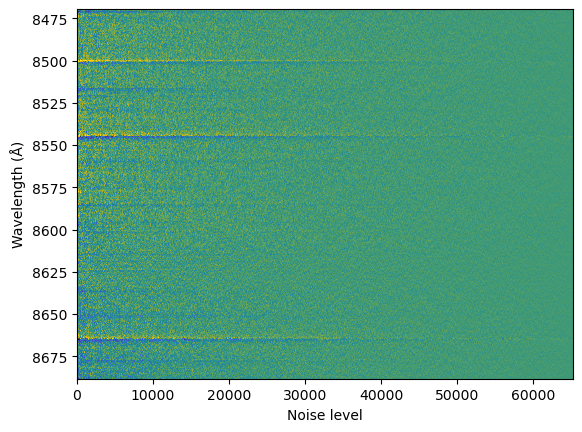

PyObject Text(25.953125, 0.5, 'Wavelength (Å)')

In [17]:
my_residuals = h5read("../all_gaia_masked/all_files_in_order.h5", "residuals")[star_msk,1:size(masked_fluxes,2)][:,ps1];
my_stellar_components = h5read("../all_gaia_masked/all_files_in_order.h5", "star_components")[star_msk,1:size(masked_fluxes,2)][:,ps1];
print(maximum(my_residuals))
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

img = ax.imshow(100*(my_residuals./my_stellar_components),
    cmap="cet_gouldian",
    aspect="auto",
    vmin=-2,
    vmax=2,
    # extent=(minimum(noises), maximum(noises),maxw,minw),
    extent=(0,size(my_residuals,2),maxw,minw),
)
plt.xlabel("Noise level")
plt.ylabel("Wavelength (Å)")

In [18]:
small_residuals = h5read("../test_new_cov_all_0.5_redo/all_files_in_order_0.5.h5", "residuals")[star_msk,1:size(masked_fluxes,2)][:,ps1];
small_stellar_components = h5read("../test_new_cov_all_0.5_redo/all_files_in_order_0.5.h5", "star_components")[star_msk,1:size(masked_fluxes,2)][:,ps1];
small_percent_residuals = 100*(small_residuals./small_stellar_components);

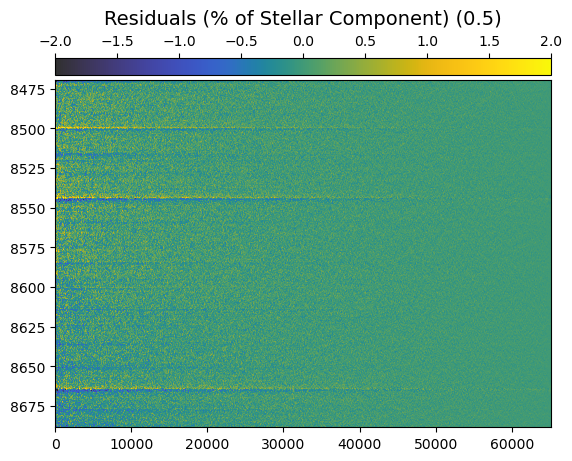

PyObject Text(0.5, 436.7666666666667, 'Residuals (% of Stellar Component) (0.5)')

In [19]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

img = ax.imshow(small_percent_residuals,
    cmap="cet_gouldian",
    aspect="auto",
    vmin=-2,
    vmax=2,
    # extent=(minimum(noises), maximum(noises),maxw,minw),
    extent=(0,size(small_percent_residuals,2),maxw,minw),
)

divider = mpltk.make_axes_locatable(ax)
cax = divider.append_axes("top", size="5%", pad=0.05)
cbar = plt.colorbar(img, cax=cax, orientation="horizontal")
cax.xaxis.set_ticks_position("top")
cax.xaxis.set_label_position("top")
cax.set_xlabel("Residuals (% of Stellar Component) (0.5)",fontsize=14,labelpad=7)

In [20]:
outlst = h5open("../test_new_cov_all_200_redo/_wu/μ_bd0.h5")
large_stellar_components = read(outlst["μ_bd0"])[star_msk,:][:,ps1];
outlst2 = h5open("../test_new_cov_all_200_redo/_wu/μ_cd0.h5")
large_residuals  = read(outlst2["μ_cd0"])[star_msk,:][:,ps1];
large_percent_residuals = 100*(large_residuals./large_stellar_components);

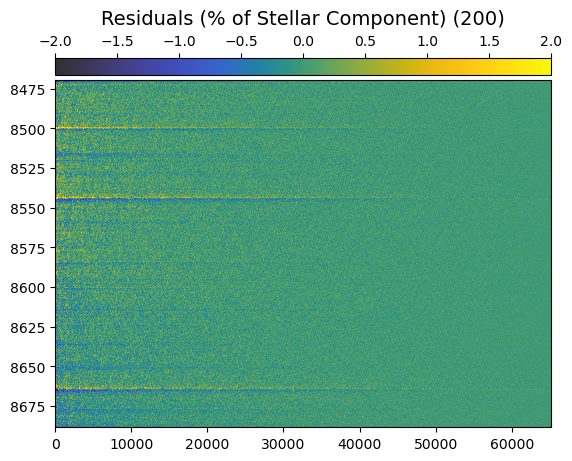

PyObject Text(0.5, 436.7666666666667, 'Residuals (% of Stellar Component) (200)')

In [21]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

img = ax.imshow(large_percent_residuals,
    cmap="cet_gouldian",
    aspect="auto",
    vmin=-2,
    vmax=2,
    # extent=(minimum(noises), maximum(noises),maxw,minw),
    extent=(0,size(large_residuals,2),maxw,minw),
)

divider = mpltk.make_axes_locatable(ax)
cax = divider.append_axes("top", size="5%", pad=0.05)
cbar = plt.colorbar(img, cax=cax, orientation="horizontal")
cax.xaxis.set_ticks_position("top")
cax.xaxis.set_label_position("top")
cax.set_xlabel("Residuals (% of Stellar Component) (200)",fontsize=14,labelpad=7)

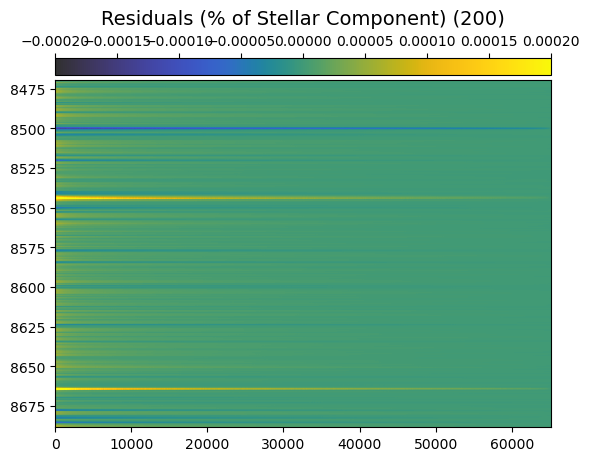

PyObject Text(0.5, 436.7666666666667, 'Residuals (% of Stellar Component) (200)')

In [22]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

img = ax.imshow(large_percent_residuals .- small_percent_residuals,
    cmap="cet_gouldian",
    aspect="auto",
    vmin=-0.0002,
    vmax=0.0002,
    # extent=(minimum(noises), maximum(noises),maxw,minw),
    extent=(0,size(large_residuals,2),maxw,minw),
)

divider = mpltk.make_axes_locatable(ax)
cax = divider.append_axes("top", size="5%", pad=0.05)
cbar = plt.colorbar(img, cax=cax, orientation="horizontal")
cax.xaxis.set_ticks_position("top")
cax.xaxis.set_label_position("top")
cax.set_xlabel("Residuals (% of Stellar Component) (200)",fontsize=14,labelpad=7)

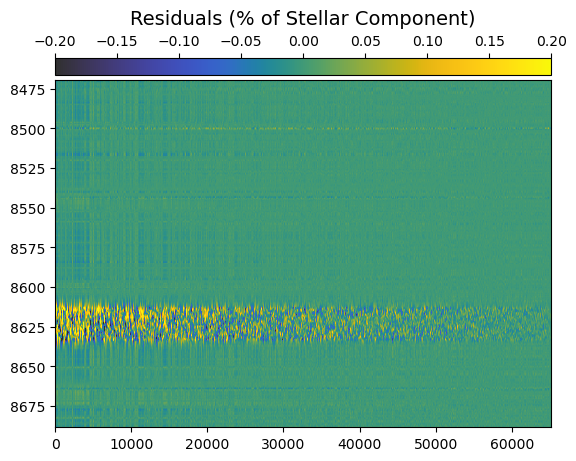

PyObject Text(0.5, 436.7666666666667, 'Residuals (% of Stellar Component)')

In [24]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

img = ax.imshow(100*(my_residuals./my_stellar_components) - large_percent_residuals,
    cmap="cet_gouldian",
    aspect="auto",
    vmin=-0.2,
    vmax=0.2,
    # extent=(minimum(noises), maximum(noises),maxw,minw),
    extent=(0,size(large_residuals,2),maxw,minw),
)

divider = mpltk.make_axes_locatable(ax)
cax = divider.append_axes("top", size="5%", pad=0.05)
cbar = plt.colorbar(img, cax=cax, orientation="horizontal")
cax.xaxis.set_ticks_position("top")
cax.xaxis.set_label_position("top")
cax.set_xlabel("Residuals (% of Stellar Component)",fontsize=14,labelpad=7)

In [23]:
Cstar = h5open(andrew_dir*"priors/RVS_stellar_zeroweighted_kry_50_95_const.h5")

🗂️ HDF5.File: (read-only) /uufs/chpc.utah.edu/common/home/u6039752/scratch/zenodo/GaiaDIB/GaiaDIB_dat/priors/RVS_stellar_zeroweighted_kry_50_95_const.h5
├─ 🔢 Cstar
├─ 🔢 Cstarinv
├─ 🔢 Vmat
├─ 🔢 msk
├─ 🔢 train_source_id
├─ 🔢 λinv
└─ 🔢 λv

In [24]:
λv= read(Cstar["λv"]);

In [27]:
sqrt(0.1)

0.31622776601683794

In [26]:
Vmat  = read(Cstar["Vmat"]);

2189×50 Matrix{Float64}:
 0.316764   0.0143495  -0.0172509    …  -0.0003371    -0.00013671
 0.316656   0.016909   -0.0142991       -0.000399995  -0.000159335
 0.31647    0.0215438  -0.00919907      -0.000450987  -0.000139248
 0.316277   0.0257685  -0.00372595      -0.000507083  -0.000109949
 0.316133   0.0279552   0.000595916     -0.000542184  -0.000121998
 0.316066   0.0273959   0.0030028    …  -0.000486867  -0.000157393
 0.316089   0.0227475   0.00345745      -0.000380494  -0.00024082
 0.316225   0.0106487   0.00205021      -0.000306619  -0.000309684
 0.31651   -0.0131633  -0.00135726      -0.000290204  -0.000267064
 0.316959  -0.050197   -0.00690771      -0.000260657  -0.000165256
 0.317522  -0.0956935  -0.0141691    …  -0.000193115  -6.02286e-5
 0.318075  -0.138461   -0.021759        -9.17567e-5    8.63329e-8
 0.318459  -0.165322   -0.0277313       -2.23804e-5    3.75478e-5
 ⋮                                   ⋱                
 0.315645   0.0593387   0.00843533       0.00014997   

In [92]:
outlst = h5open("../test_new_cov_all_200_redo/_wu/μ_bd0.h5")

🗂️ HDF5.File: (read-only) ../test_new_cov_all_200_redo/_wu/μ_bd0.h5
└─ 🔢 μ_bd0

In [93]:
new_stellar_components_v1 = read(outlst["μ_bd0"])[star_msk,:][:,ps1];
outlst2 = h5open("../test_new_cov_all_200_redo/_wu/μ_cd0.h5")
new_residuals_v1 = read(outlst2["μ_cd0"])[star_msk,:][:,ps1];

In [82]:
size(new_residuals)

(2189, 65186)

0.15854122878157395 1.0248715596584461

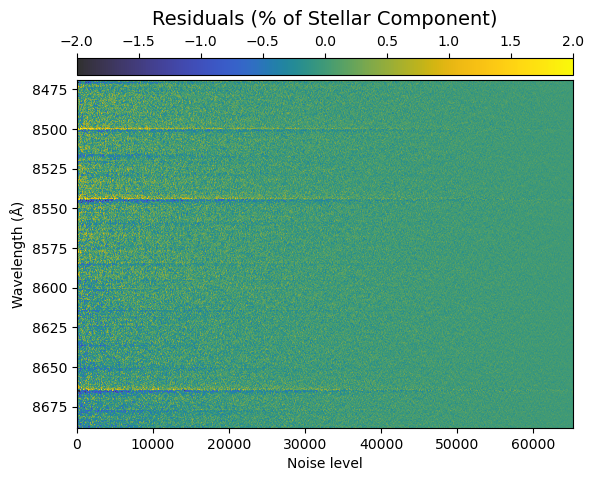

PyObject Text(0.5, 456.32222222222225, 'Residuals (% of Stellar Component)')

In [83]:
print(maximum(new_residuals[:,1]), " ", maximum(new_stellar_components[:,1]))

fig = plt.figure()
ax = fig.add_subplot(1,1,1)

img = ax.imshow(100*(new_residuals_v1./new_stellar_components_v1),
    cmap="cet_gouldian",
    aspect="auto",
    vmin=-2,
    vmax=2,
    # extent=(minimum(noises), maximum(noises),maxw,minw),
    extent=(0,size(new_residuals,2),maxw,minw),
)
plt.xlabel("Noise level")
plt.ylabel("Wavelength (Å)")

divider = mpltk.make_axes_locatable(ax)
cax = divider.append_axes("top", size="5%", pad=0.05)
cbar = plt.colorbar(img, cax=cax, orientation="horizontal")
cax.xaxis.set_ticks_position("top")
cax.xaxis.set_label_position("top")
cax.set_xlabel("Residuals (% of Stellar Component)",fontsize=14,labelpad=7)

In [94]:
percent_residuals_1 = 100*(new_residuals_v1./new_stellar_components_v1);

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

img = ax.imshow(percent_residuals_1 .- percent_residuals_2,
    cmap="cet_gouldian",
    aspect="auto",
    vmin=-0.0002,
    vmax=0.0002,
    # extent=(minimum(noises), maximum(noises),maxw,minw),
    extent=(0,size(new_residuals,2),maxw,minw),
)

divider = mpltk.make_axes_locatable(ax)
cax = divider.append_axes("top", size="5%", pad=0.05)
cbar = plt.colorbar(img, cax=cax, orientation="horizontal")
cax.xaxis.set_ticks_position("top")
cax.xaxis.set_label_position("top")
cax.set_xlabel("Residuals (% of Stellar Component)",fontsize=14,labelpad=7)

0.15854122878157395 1.0248715596584461

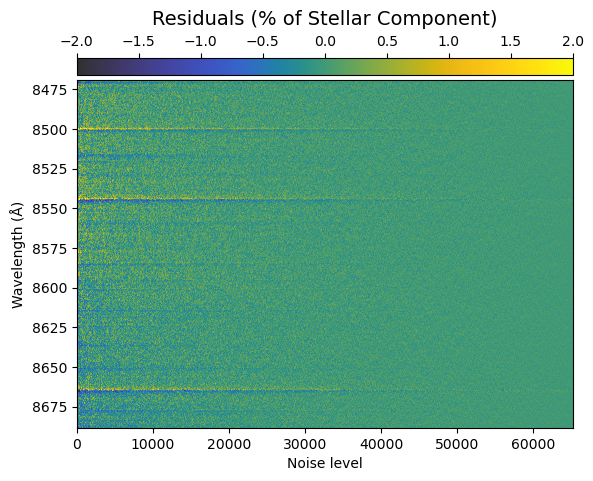

PyObject Text(0.5, 456.32222222222225, 'Residuals (% of Stellar Component)')

In [18]:
new_residuals = h5read("../test_new_cov_all_0.5_redo/all_files_in_order_0.5.h5", "residuals")[star_msk,1:size(masked_fluxes,2)][:,ps1];
new_stellar_components = h5read("../test_new_cov_all_0.5_redo/all_files_in_order_0.5.h5", "star_components")[star_msk,1:size(masked_fluxes,2)][:,ps1];
print(maximum(new_residuals[:,1]), " ", maximum(new_stellar_components[:,1]))

fig = plt.figure()
ax = fig.add_subplot(1,1,1)

img = ax.imshow(100*(new_residuals./new_stellar_components),
    cmap="cet_gouldian",
    aspect="auto",
    vmin=-2,
    vmax=2,
    # extent=(minimum(noises), maximum(noises),maxw,minw),
    extent=(0,size(new_residuals,2),maxw,minw),
)
plt.xlabel("Noise level")
plt.ylabel("Wavelength (Å)")

divider = mpltk.make_axes_locatable(ax)
cax = divider.append_axes("top", size="5%", pad=0.05)
cbar = plt.colorbar(img, cax=cax, orientation="horizontal")
cax.xaxis.set_ticks_position("top")
cax.xaxis.set_label_position("top")
cax.set_xlabel("Residuals (% of Stellar Component)",fontsize=14,labelpad=7)

0.3764806563856193 1.1027657220220644

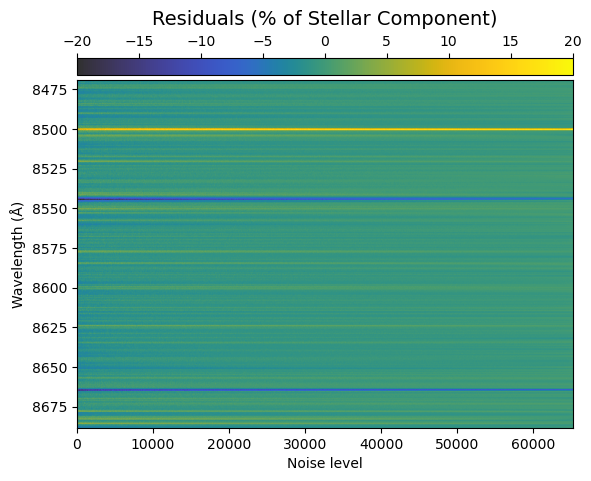

PyObject Text(0.5, 456.32222222222225, 'Residuals (% of Stellar Component)')

In [21]:
new_residuals = h5read("../test_new_cov_all_0.05/all_files_in_order_0.05.h5", "residuals")[star_msk,1:size(masked_fluxes,2)][:,ps1];
new_stellar_components = h5read("../test_new_cov_all_0.05/all_files_in_order_0.05.h5", "star_components")[star_msk,1:size(masked_fluxes,2)][:,ps1];
print(maximum(new_residuals), " ", maximum(new_stellar_components))

fig = plt.figure()
ax = fig.add_subplot(1,1,1)

img = ax.imshow(100*(new_residuals./new_stellar_components),
    cmap="cet_gouldian",
    aspect="auto",
    vmin=-20,
    vmax=20,
    # extent=(minimum(noises), maximum(noises),maxw,minw),
    extent=(0,size(new_residuals,2),maxw,minw),
)
plt.xlabel("Noise level")
plt.ylabel("Wavelength (Å)")

divider = mpltk.make_axes_locatable(ax)
cax = divider.append_axes("top", size="5%", pad=0.05)
cbar = plt.colorbar(img, cax=cax, orientation="horizontal")
cax.xaxis.set_ticks_position("top")
cax.xaxis.set_label_position("top")
cax.set_xlabel("Residuals (% of Stellar Component)",fontsize=14,labelpad=7)

0.3764806563860408 1.1027657220222766

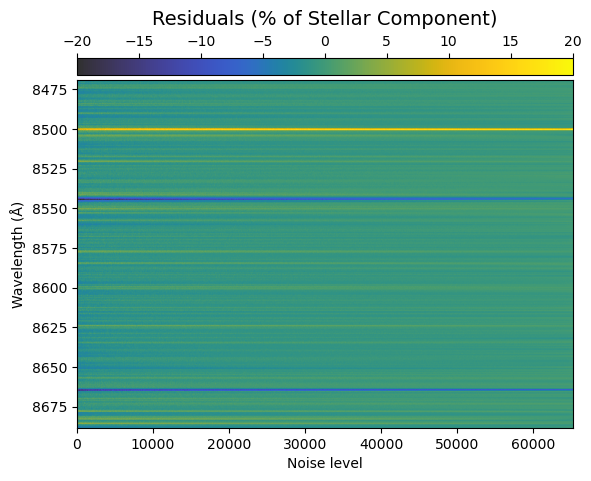

PyObject Text(0.5, 456.32222222222225, 'Residuals (% of Stellar Component)')

In [23]:
new_residuals = h5read("../test_new_cov_all_0.2_redo/all_files_in_order_0.2_redo.h5", "residuals")[star_msk,1:size(masked_fluxes,2)][:,ps1];
new_stellar_components = h5read("../test_new_cov_all_0.2_redo/all_files_in_order_0.2_redo.h5", "star_components")[star_msk,1:size(masked_fluxes,2)][:,ps1];
print(maximum(new_residuals), " ", maximum(new_stellar_components))

fig = plt.figure()
ax = fig.add_subplot(1,1,1)

img = ax.imshow(100*(new_residuals./new_stellar_components),
    cmap="cet_gouldian",
    aspect="auto",
    vmin=-20,
    vmax=20,
    # extent=(minimum(noises), maximum(noises),maxw,minw),
    extent=(0,size(new_residuals,2),maxw,minw),
)
plt.xlabel("Noise level")
plt.ylabel("Wavelength (Å)")

divider = mpltk.make_axes_locatable(ax)
cax = divider.append_axes("top", size="5%", pad=0.05)
cbar = plt.colorbar(img, cax=cax, orientation="horizontal")
cax.xaxis.set_ticks_position("top")
cax.xaxis.set_label_position("top")
cax.set_xlabel("Residuals (% of Stellar Component)",fontsize=14,labelpad=7)

In [24]:
size(my_residuals)

(2189, 65186)